***Import library***

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

***Hyper Parameters***

In [31]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

batch_size = 8
num_epochs = 150
learning_rate = 0.0011

threshold = 0.0011679699386776773
data_size = [10, 30, 60, 90, 120, 150, 230, 300]

normal_dir = 'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CNN_dataset300\\normal'
abnormal_dir = 'C:\\Users\\WorkStation\\Desktop\\캡디이미지\\CNN_dataset300\\abnormal'

***Load Datasets***

In [32]:
normal_images = datasets.ImageFolder(
    normal_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)

abnormal_images = datasets.ImageFolder(
    abnormal_dir,
    transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
)
    

labeled_abnormal_images = []
for feature, index in abnormal_images:
    labeled_abnormal_images.append([feature, 1])

***Model***

In [33]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5) 
        self.conv3 = nn.Conv2d(12, 24, 4)  
        self.fc1 = nn.Linear(24 * 25 * 25, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 6 * 110 * 110
        x = self.pool(F.relu(self.conv2(x))) # 12 * 53 * 53
        x = self.pool(F.relu(self.conv3(x))) # 24 * 25 * 25
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [34]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        
        # Encoder
        self.cnn_layer1 = nn.Sequential(
                        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                         nn.MaxPool2d(2,2))

        self.cnn_layer2 = nn.Sequential(
                                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                 nn.MaxPool2d(2,2))
        
        self.cnn_layer3 = nn.Sequential(
                                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                nn.ReLU(),
                                 nn.MaxPool2d(2,2))

        # Decoder        
        self.tran_cnn_layer1 = nn.Sequential(
                        nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2, padding=0),
                        nn.ReLU())
        
        self.tran_cnn_layer2 = nn.Sequential(
                        nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2, padding=0),
                        nn.ReLU())

        self.tran_cnn_layer3 = nn.Sequential(
                        nn.ConvTranspose2d(16, 3, kernel_size = 2, stride = 2, padding=0),
                        nn.Sigmoid())  
            
    def forward(self, x):
        output = self.cnn_layer1(x)
        output = self.cnn_layer2(output)
        output = self.cnn_layer3(output)        
        output = self.tran_cnn_layer1(output)
        output = self.tran_cnn_layer2(output)
        output = self.tran_cnn_layer3(output)

        return output

In [35]:
AE = ConvAutoEncoder()
AE.load_state_dict(torch.load('best_model_final.pth'))
AE.to(device)

ae_criterion = nn.MSELoss()
cnn_criterion = nn.CrossEntropyLoss()

***Train & Test***

In [36]:
import datetime
now = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

cnn_err_rate = []
ae_err_rate = []

for number, dsize in enumerate(data_size, 0):
    
    print(f"Number of abnormal data : {dsize}")
    
    train_loader = torch.utils.data.DataLoader(normal_images + labeled_abnormal_images[:dsize], batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(normal_images + labeled_abnormal_images[:dsize], batch_size=batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(labeled_abnormal_images[:dsize], batch_size=batch_size, shuffle = True)
    
    cnn = CNN()
    cnn.to(device)
    
    optimizer = torch.optim.SGD(cnn.parameters(), lr=learning_rate)
    
    file_name = f"data/[{now}]_best_model_final_{number}.pth"
    
    ########## CNN Train ##########
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = cnn(inputs)
            cnn_loss = cnn_criterion(outputs, labels)
            cnn_loss.backward()
            optimizer.step()

            running_loss += cnn_loss.item()
        
        if epoch % 10 == 0:
            print(f"[{epoch}/{num_epochs}] loss : {running_loss/len(train_loader)}")

    print('Finished Training')
            
    ########## Test CNN & CAE ##########    
    
    with torch.no_grad():
        error = 0
        total = 0
        ae_err = 0
        
        ##### CNN #####
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = cnn(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            error += (predicted != labels).sum().item()
            
        print(f"CNN error rate : {error / total}")        
        cnn_err_rate.append(error / total)
            
        ##### CAE #####
        for i, (X_abnormal, _) in enumerate(val_loader):
            X_abnormal = X_abnormal.to(device)
            output = AE(X_abnormal)
            ae_loss = ae_criterion(X_abnormal, output)
        
            if ae_loss.item() < threshold:
                ae_err += 1
        
        ae_err_rate.append(ae_err / len(val_loader)*batch_size)
        print(f"AE error rate : {ae_err / len(val_loader)*batch_size}")
        
        torch.save(cnn.state_dict(), file_name)
        print("save model " + file_name ,"\n")
            
            
            
            
            #output = AE(images)
            #ae_loss = ae_criterion(images, output)
    
            #if labels == 0 and ae_loss.item() > threshold:
            #    ae_err += 1
            #elif labels == 1 and ae_loss.item() < threshold:
            #    ae_err += 1


    with open(f'[{now}]-error-rate.txt', 'a') as f:
        f.write(f'{dsize} {error/len(test_loader)} {ae_err / len(val_loader)}\n')

Number of abnormal data : 10
[0/150] loss : 0.7073914036154747
[10/150] loss : 0.6874997690320015
[20/150] loss : 0.6698679178953171
[30/150] loss : 0.6537731066346169
[40/150] loss : 0.6385691240429878
[50/150] loss : 0.6246192455291748
[60/150] loss : 0.6117883622646332
[70/150] loss : 0.5999446138739586
[80/150] loss : 0.5894700735807419
[90/150] loss : 0.5782598704099655
[100/150] loss : 0.5661422684788704
[110/150] loss : 0.5530257374048233
[120/150] loss : 0.5404968373477459
[130/150] loss : 0.5337466672062874
[140/150] loss : 0.531544778496027
Finished Training
CNN error rate : 0.16666666666666666
AE error rate : 0.0
save model data/[2021-12-30_19-14-05]_best_model_final_0.pth 

Number of abnormal data : 30
[0/150] loss : 0.6998011410236359
[10/150] loss : 0.6894962549209595
[20/150] loss : 0.683375608921051
[30/150] loss : 0.6781247854232788
[40/150] loss : 0.6735257387161255
[50/150] loss : 0.6694656014442444
[60/150] loss : 0.6666956007480621
[70/150] loss : 0.665141421556472

***Graph***

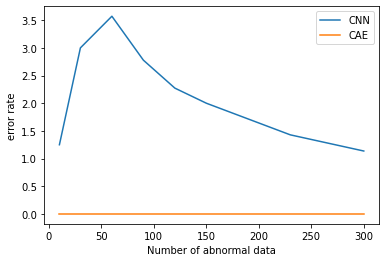

In [37]:
with open(f'[{now}]-error-rate.txt', 'r') as f:
    data = f.readlines()
    
    num_abnormal = []
    cnn_err_rate = []
    ae_err_rate = []
    
    for index in data:
        num, cnn, ae = tuple(map(float, index.split()))
        
        num_abnormal.append(num)
        cnn_err_rate.append(cnn)
        ae_err_rate.append(ae)
        
plt.plot(num_abnormal, cnn_err_rate, label = 'CNN')
plt.plot(num_abnormal, ae_err_rate, label = 'CAE')
plt.xlabel('Number of abnormal data')
plt.ylabel('error rate')
plt.legend()
plt.show()